In [1]:
import numpy as np
import pandas as pd
import pickle
from utils import load_PENN_data, decompose_Y, generate_simulation_components, parallel_experiments

In [2]:
# set n_jobs to the number of cores
num_cores = 36
num_experiments = 10000

### Varying T_pre

In [4]:
data_dict = {}
RMSE = {}
bias = {}

setting = 'Baseline' 
config = ['log_gdp', 'dem', None]

TROP_dict = {'Baseline': [0.3, 0.4, 0.006]}

for S in np.arange(8,25)*2:    
#for S in [48]:
    print(S)
    
    # load and process data for each setting
    outcome, treatment, option = config
    data = load_PENN_data(outcome, treatment, short_panel=S)
    data_dict[S] = data
    
    # run simulations
    simulation_components = generate_simulation_components(data)
    np.random.seed(0)
    RMSE[S], bias[S] = parallel_experiments(num_cores, num_experiments, simulation_components, TROP_dict[setting], option)

16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48


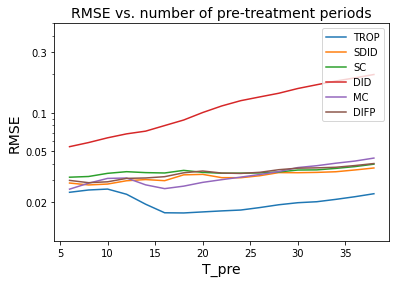

In [5]:
results = np.array(list(RMSE.values()))
estimators = ['TROP','SDID','SC','DID','MC','DIFP']
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

for e in range(results.shape[1]):
    
    plt.plot(np.array(list(RMSE.keys()))-10, (results[:,e]),label=estimators[e])
    plt.yscale('log')

plt.yticks([0.3,0.1, 0.05, 0.02], labels=[0.3,0.1, 0.05, 0.02])
plt.xlabel('T_pre', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('RMSE vs. number of pre-treatment periods', fontsize=14)
plt.legend(loc='upper right')
plt.ylim(0.01,0.5)
plt.savefig("PENN_T_10_10_plot.pdf", format="pdf")
    
plt.show()

### Varying T_tr

In [3]:
data_dict = {}
RMSE = {}
bias = {}

setting = 'Baseline' 
config = ['log_gdp', 'dem', 'T_post=1']

TROP_dict = {'Baseline': [0.3, 0.4, 0.006]}
#TROP_dict = {'Baseline': [0.4, 0.1, 0.1012]}

#TROP_dict={'Random': [0.4, 0.45, 0.003]}

for S in np.arange(10):    
#for S in [48]:
    
    # load and process data for each setting
    outcome, treatment, option = config
    option = 'T_post='+str(S+1)
    print(option)
    #data = load_PENN_data(outcome, treatment)
    data = load_PENN_data(outcome, treatment, short_panel=48-(9-S))
    data_dict[S] = data
    
    # run simulations
    simulation_components = generate_simulation_components(data)
    np.random.seed(0)
    RMSE[S], bias[S] = parallel_experiments(num_cores, num_experiments, simulation_components, TROP_dict[setting], option)
    #RMSE[S] = r/np.min(r)

T_post=1
T_post=2
T_post=3
T_post=4
T_post=5
T_post=6
T_post=7
T_post=8
T_post=9
T_post=10


In [4]:
RMSE

{0: array([0.01687995, 0.01862479, 0.0226603 , 0.11432272, 0.01892964,
        0.02147952]),
 1: array([0.01842648, 0.02431737, 0.02522515, 0.12295353, 0.01993398,
        0.02585995]),
 2: array([0.01877018, 0.02831764, 0.02672905, 0.13024331, 0.01978503,
        0.02830049]),
 3: array([0.01855391, 0.0293906 , 0.02841251, 0.14000641, 0.01965915,
        0.02987867]),
 4: array([0.01817394, 0.03064126, 0.02917156, 0.14846308, 0.02023534,
        0.03068273]),
 5: array([0.01849994, 0.03478941, 0.03105364, 0.15993803, 0.02237794,
        0.03288289]),
 6: array([0.01993766, 0.0392286 , 0.03374638, 0.16963605, 0.02732866,
        0.03691757]),
 7: array([0.02319766, 0.03677914, 0.03510645, 0.18058182, 0.03362381,
        0.03608357]),
 8: array([0.02308026, 0.03937051, 0.0369302 , 0.19011966, 0.03793024,
        0.03852666]),
 9: array([0.02332541, 0.03706265, 0.03969936, 0.19921791, 0.04429764,
        0.04014475])}

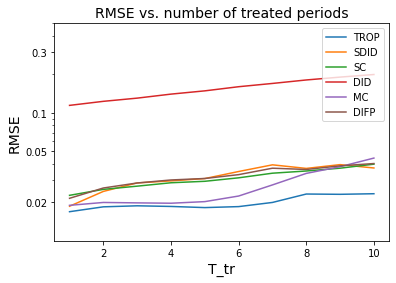

In [5]:
results = np.array(list(RMSE.values()))
estimators = ['TROP','SDID','SC','DID','MC','DIFP']
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

for e in range(results.shape[1]):
    
    plt.plot(np.array(list(RMSE.keys()))+1, (results[:,e]),label=estimators[e])
    plt.yscale('log')

plt.yticks([0.3,0.1, 0.05, 0.02], labels=[0.3,0.1, 0.05, 0.02])
plt.xlabel('T_tr',fontsize=14)
plt.ylabel('RMSE',fontsize=14)
plt.title('RMSE vs. number of treated periods',fontsize=14)
plt.ylim(0.01,0.5)
plt.legend()

plt.savefig("PENN_T_tr_plot.pdf", format="pdf")
    
plt.show()

# Optimal Tuning Parameter

In [58]:
from methods import TROP_TWFE_average
from utils import generate_data
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [83]:
np.random.seed(0)
outcome, treatment, option = ['log_gdp', 'dem', None]
data = load_PENN_data(outcome, treatment,short_panel=48)
F, M, cov_mat, pi = generate_simulation_components(data)

In [84]:
Y_true, _, _, _ = generate_data(F, M, cov_mat, pi, option)
treated_periods = 1
treated_unit_number = 1

In [85]:
def get_ATE(trial, Y_true, lambda_unit, lambda_time, lambda_nn):
    np.random.seed(trial)
    N_total, _ = Y_true.shape
    #test_units = np.random.choice(np.arange(N_total), size=treated_unit_number,replace=False)
    candidates = np.random.binomial(n=1,p=pi)

    treated_number = np.sum(candidates)

    if treated_number == 0:
        index = np.array(np.random.choice(N_total))
    elif treated_number == 1:
        index = np.array([np.squeeze(np.argwhere(candidates==1))])
    else:   
        index = np.squeeze(np.argwhere(candidates==1))
        if treated_number > treated_unit_number:
            index = np.random.choice(index, size=treated_unit_number, replace=False)
            
    test_units = index
                
    W_test = np.zeros(Y_true.shape)
    W_test[test_units,-treated_periods:] = 1
    estimate = TROP_TWFE_average(Y_true,W_test, test_units,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
    return estimate

In [86]:
Y_true.shape

(111, 48)

## Select lambda_unit

In [102]:
Q = []
lambda_units = np.arange(0,2,2/10)
for lambda_unit in lambda_units:
    lambda_time = 2.7
    lambda_nn = 0.0211
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0.0 2.7 0.0211
0.05527210556959953
0.2 2.7 0.0211
0.055317666652553416
0.4 2.7 0.0211
0.05533447663373539
0.6000000000000001 2.7 0.0211
0.05534443502455178
0.8 2.7 0.0211
0.05536909368774632
1.0 2.7 0.0211
0.05542021102647867
1.2000000000000002 2.7 0.0211
0.05550111436388795
1.4000000000000001 2.7 0.0211
0.05561079663769583
1.6 2.7 0.0211
0.05574678249796028
1.8 2.7 0.0211
0.055906447606212745


In [103]:
lambda_units[np.argmin(Q)]

0.0

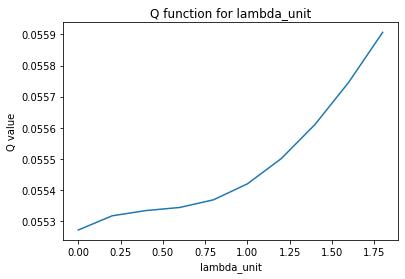

In [104]:
plt.plot(lambda_units,Q)
plt.xlabel('lambda_unit')
plt.ylabel('Q value')
plt.title('Q function for lambda_unit')
plt.show()

## Select lambda_time

In [105]:
Q = []
lambda_times = np.arange(0,3,3/10)
for lambda_time in lambda_times:
    lambda_nn = 0.0211
    lambda_unit = 0
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0 0.0 0.0211
0.06608090415092963
0 0.3 0.0211
0.061531993900774934
0 0.6 0.0211
0.060854872622399
0 0.8999999999999999 0.0211
0.060088189820943064
0 1.2 0.0211
0.05712362950616742
0 1.5 0.0211
0.055962830392029025
0 1.7999999999999998 0.0211
0.0556161323999372
0 2.1 0.0211
0.05542911956279724
0 2.4 0.0211
0.055327531357728534
0 2.6999999999999997 0.0211
0.05527210556959564


In [106]:
lambda_times[np.argmin(Q)]

2.6999999999999997

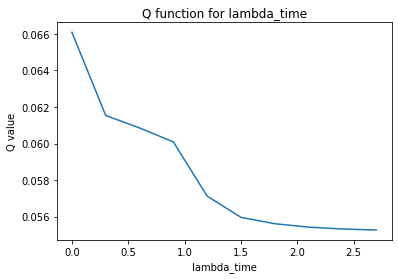

In [107]:
plt.plot(lambda_times,Q)
plt.xlabel('lambda_time')
plt.ylabel('Q value')
plt.title('Q function for lambda_time')
plt.show()

### Select lambad_nn

In [108]:
Q = []
lambda_nns = np.arange(0.001,0.2,0.201/10)
for lambda_nn in lambda_nns:
    lambda_time = 2.7
    lambda_unit = 0
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

0 2.7 0.001
0.05527210556842182
0 2.7 0.0211
0.05527210556959953
0 2.7 0.0412
0.055272105572888405
0 2.7 0.0613
0.05527210557820157
0 2.7 0.0814
0.05527210558540253
0 2.7 0.1015
0.055272107141115474
0 2.7 0.1216
0.055272107141115454
0 2.7 0.1417
0.05527210714111546
0 2.7 0.1618
0.05527210714111547
0 2.7 0.1819
0.05527210714111547


In [109]:
lambda_nns[np.argmin(Q)]

0.001

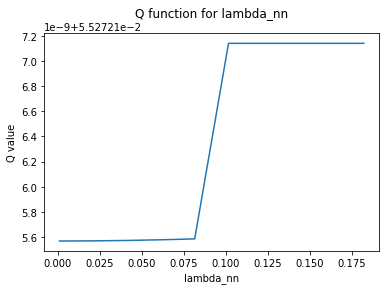

In [110]:
plt.plot(lambda_nns,Q)
plt.xlabel('lambda_nn')
plt.ylabel('Q value')
plt.title('Q function for lambda_nn')
plt.show()